In [93]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict ,Literal
import warnings
import os
warnings.filterwarnings("ignore")
from dotenv import load_dotenv
from pydantic import BaseModel , Field
from langchain.output_parsers import PydanticOutputParser


In [94]:
from langchain_google_genai import GoogleGenerativeAI
load_dotenv()
llm = GoogleGenerativeAI(
    model="gemini-2.5-pro",  # Use correct model name
    google_api_key=os.getenv('GOOGLE_API_KEY')  # Explicit API key
)

In [95]:
class Sentimentschema(BaseModel):
    
    sentiment :Literal["positive",'negative'] = Field(description="Sentiment of the review")

In [96]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [97]:
# Parser
parser_sentiment  = PydanticOutputParser(pydantic_object=Sentimentschema)

In [98]:
parser_diagnostic = PydanticOutputParser(pydantic_object=DiagnosisSchema)

In [99]:
def structured_review_invoke(review: str) -> Sentimentschema:
    prompt = (
        f"Review: {review}\n"
        "Reply strictly in JSON format like {\"sentiment\": \"positive\"} "
        "with sentiment being either 'positive' or 'negative'. Do not add any extra text."
    )
    raw_response = llm.predict(prompt)
    parsed =parser_sentiment.parse(raw_response)
    return parsed.sentiment


In [100]:
def structured_diagnosis_invoke(review: str) -> DiagnosisSchema:
    prompt = (
        f"Review: {review}\n"
        "Analyze the review and reply strictly in JSON format with the following keys:\n"
        "{\"issue_type\": <one of UX, Performance, Bug, Support, Other>, "
        "\"tone\": <one of angry, frustrated, disappointed, calm>, "
        "\"urgency\": <one of low, medium, high>}\n"
        "Do not add any extra text or explanation. Only valid JSON with the specified values."
    )
    raw_response = llm.predict(prompt)
    parsed = parser_diagnostic.parse(raw_response)
    return parsed

    

In [101]:
class Reviewstate(TypedDict):
    review :str
    sentiment :Literal['positive','negative']
    diagnosis :dict
    response :str

In [102]:
# testing  the review state

review_text = "The product has snide effects"
sentiment_result = structured_review_invoke(review_text)

state:Reviewstate ={"review":review_text,
                    "sentiment":sentiment_result}


print(state)

{'review': 'The product has snide effects', 'sentiment': 'negative'}


In [112]:
def find_sentiment(state:Reviewstate)->Reviewstate:
    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_review_invoke(prompt)
    return {"sentiment":sentiment}

def check_sentiment(state:Reviewstate)->Reviewstate:
    if state["sentiment"] == "positive":
        return "positive"
    else:
        return "negative"

def positive_response(state:Reviewstate)->Reviewstate:

    prompt = f"""
    write a short thank you note appreciating it,keept it short
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website.
"""
    response = llm.invoke(prompt)
    return {"response":response}

def run_diagnosis( state:Reviewstate)->Reviewstate:

     prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
     response = structured_diagnosis_invoke(prompt)
     return {"diagnosis":response.model_dump()}

def negative_response(state:Reviewstate)->Reviewstate:

    diagnosis = state['diagnosis']
    prompt =    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = llm.invoke(prompt)

    return{"response":response}


In [ ]:

"""
graph = StateGraph(Reviewstate)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()
"""

In [113]:


graph = StateGraph(Reviewstate)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

# **THE FIX IS HERE:** You need to map the output of check_sentiment
# to the nodes you want to route to.
graph.add_conditional_edges(
    'find_sentiment',
    check_sentiment,
    {
        "positive": "positive_response",  # If check_sentiment returns "positive", go to 'positive_response'
        "negative": "run_diagnosis"       # If check_sentiment returns "negative", go to 'run_diagnosis'
    }
)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

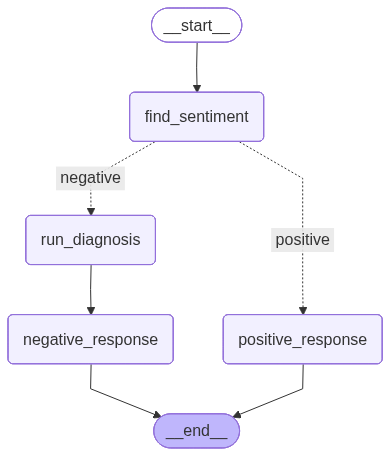

In [114]:
workflow

In [115]:


intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}

final_state =   workflow.invoke(intial_state)
print(final_state["response"])





Of course. Here are a few options, ranging from a standard template to a more personalized one.

### Option 1: The Go-To Template (Clear, Empathetic, Action-Oriented)

**Subject: Re: High Urgency Bug Report**

Hi [User Name],

Thank you for reaching out and reporting this. I'm so sorry to hear about the trouble this bug is causing you. I can absolutely understand your frustration when something isn't working as expected, and I want to assure you that we're taking this with the high urgency it deserves.

To help our engineering team investigate and resolve this for you as quickly as possible, could you please provide a few more details?

*   Could you describe the steps you were taking right before the bug occurred?
*   What was the unexpected outcome?
*   If you have any screenshots, error messages, or a short screen recording of the issue, that would be incredibly helpful.

Once I have this information, I will personally escalate it to the right team and keep you updated on our progre

In [ ]:
intial_state={
    'review':"The app is working good it is very fast and it solves most of my issues . thank you for this product"
}

final_state =   workflow.invoke(intial_state)
print(final_state["response"])

In [ ]:
intial_state={
    'review':"his app is very bad you guys are theives?"
}

final_state =   workflow.invoke(intial_state)
print(final_state["response"])

Of course. Here is an empathetic and helpful resolution message crafted to de-escalate the situation and provide a clear path forward.

***

**Subject: Regarding Your Urgent Support Request [Ticket #XXXXXX]**

Hi [User Name],

I want to start by sincerely apologizing for the frustration and difficulty you've experienced. I’ve reviewed your message, and I completely understand your anger and the urgency of this situation. The experience you described is not the standard we aim for, and I am truly sorry that we let you down.

I have personally taken ownership of your case, and it is now my highest priority.

I am actively investigating the issue right now to determine the cause and find the fastest possible solution. You will not be passed around to different agents. I will be your single point of contact until this is fully resolved.

I will provide you with a meaningful update within the next **[e.g., 60 minutes / 2 hours]**. You will not have to chase me for information; I will proact